In [3]:
import ROOT
import math
# Colors
from ROOT import kYellow, kBlue, kRed, kGreen
import numpy as np
from rootpy.plotting import Hist, HistStack, Legend, Canvas, set_style
from rootpy.plotting.style import get_style, set_style
from rootpy.plotting.utils import draw
from rootpy.interactive import wait
import rootpy.plotting.root2matplotlib as rplt
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator, MultipleLocator
from root_numpy import root2array, tree2array
from root_numpy import testdata, fill_hist
import pandas as pd

In [10]:
def getTHLimits(files, ttree, var):
    g_min = 99999999999.
    g_max = -99999999999.
    for f in files:
        aux = ROOT.TFile.Open(f)
        tree = aux.Get(ttree)
        maxv=int(round(tree.GetMaximum(var)))
        minv=int(round(tree.GetMinimum(var)))
        if(minv < g_min):
            g_min = minv
        if(maxv > g_max):
            g_max = maxv
        return g_min-1.,g_max+1.

## ROOT Function

In [36]:
def genHist(filename, ttree, var, hmin, hmax, signal=False):
    # To do: Check if var is vector or not
    # Open file .root
    file = ROOT.TFile.Open(filename)
    # Select tree. Usually we'll use "Nominal"
    tree = file.Get(ttree)
    # Create empty histogram hist
    hist = ROOT.TH1F("h",var,100,hmin,hmax) # (minv-1,maxv+1) range of the histogram
    # For each row in the tree, 
    for entry in tree:
        # we'll select the value in the var column
        event = getattr(entry,var)
        # and fill the histogram with it
        hist.Fill(event)
    # Set the histogram memory direction
    hist.SetDirectory(0)        
    ROOT.TH1F.AddDirectory(False)
    return hist

In [37]:
ttree = "Nominal"
var = "m_DTphi"
files = ["ttbar-all.root", "Wtaunu_221-all.root", "WW_Pw-all.root"] 
#files = ["ZtautauB_221.root", "ZtautauC_221.root", "ZtautauL_221.root"]

# Stacked histogram object
hs = ROOT.THStack("hs"," stacked histograms")
# colors must be bigger or size equal to the files list.
colors = [kYellow, kBlue, kRed, kGreen]
hmin, hmax = getTHLimits(files, ttree, var)
print(hmin, hmax)
hists = []

# Get stacked histogram of var for each file. 
for i in range(len(files)):
    hist = genHist(files[i], ttree, var, hmin, hmax)
    hist.SetFillColor(colors[i])
    #hist.GetXaxis().SetLimits(-3,3)
    #hist.GetYaxis().SetLimits(0, 30)
    hists.append(hist)
    hs.Add(hist)
    

-5.0 5.0


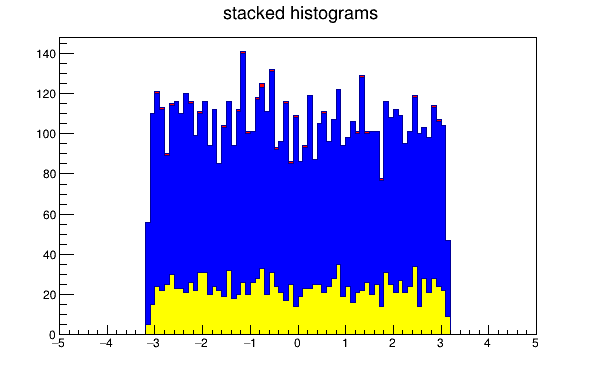

In [5]:
# Plot histogram
c = ROOT.TCanvas("Canvas",var,600,400)
hs.Draw()
#hs.GetXaxis().SetRangeUser(-3.5,3.5)
#hs.GetYaxis().SetRangeUser(0,90)
c.Draw()

## Matplotlib Function

In [11]:
# Generate dataframes from filenames arrays
def df_gen(file_arr, ttree):
    arr = []
    for f in file_arr:
        rfile = ROOT.TFile(f)
        intree = rfile.Get(ttree)
        array = tree2array(intree)
        df = pd.DataFrame(array)
        arr.append(df)
    return arr

In [23]:
def hist_gen(data, background, signal, ttree, var):
    # data, background and signal are filenames arrays
    arrB = df_gen(background, ttree)
    arrS = df_gen(signal, ttree)
    arrD = df_gen(data, ttree)
    
    # set the style
    style = get_style('ATLAS')
    style.SetEndErrorSize(3)
    set_style(style)
    
    # create histograms
    hmin, hmax = getTHLimits(background, ttree, var)
    h = Hist(100, hmin, hmax, markersize=0, legendstyle='F')
    h_sig = []
    h_bkg = []
    colors = ['red', 'blue', 'yellow', 'green', 'purple', 'brown', 'orange']
    for i in range(len(signal)):
        h_aux = h.Clone(title=signal[i].split('/')[-1].split('.', 1)[0])
        fill_hist(h_aux, arrS[i].loc[:,var])
        h_aux.fillstyle = 'solid'
        h_aux.fillcolor = colors[i]
        h_aux.linecolor = colors[i]
        h_aux.linewidth = 1
        h_sig.append(h_aux)
    for i in range(len(background)):
        h_aux = h.Clone(title=background[i].split('/')[-1].split('.', 1)[0])
        fill_hist(h_aux, arrB[i].loc[:,var])
        h_aux.fillstyle = 'solid'
        h_aux.fillcolor = colors[i+1]
        h_aux.linecolor = colors[i+1]
        h_aux.linewidth = 0
        h_bkg.append(h_aux)
    h_data = h.Clone(title=data[0].split('/')[-1].split('.', 1)[0], drawstyle='E1 X0', legendstyle='LEP')
    h_data.markersize = 1.2
    fill_hist(h_data, arrD[0].loc[:,var])
    
    # histograms stack
    stack = HistStack(h_sig + h_bkg, drawstyle='HIST E1 X0')

    # plot with ROOT
    canvas = Canvas(width=1000, height=800)
    draw([stack, h_data], xtitle=var, ytitle='Events', pad=canvas)
    
    # set the number of expected legend entries
    legend = Legend(h_sig + h_bkg, leftmargin=0.25, margin=0.1)
    legend.Draw()
    label = ROOT.TText(0.2, 0.6, 'ROOT')
    label.SetTextFont(43)
    label.SetTextSize(15)
    label.SetNDC()
    label.Draw()
    canvas.Modified()
    canvas.Update()

    # plot with matplotlib
    set_style('ATLAS', mpl=True)
    fig = plt.figure(figsize=(9, 8), dpi=100)
    axes = plt.axes()
    axes.xaxis.set_minor_locator(AutoMinorLocator())
    axes.yaxis.set_minor_locator(AutoMinorLocator())
    axes.yaxis.set_major_locator(MultipleLocator(100))
    rplt.bar(stack, stacked=True, axes=axes)
    rplt.errorbar(h_data, xerr=False, emptybins=False, axes=axes)
    plt.xlabel(var, position=(1., 0.), va='bottom', ha='right')
    plt.ylabel('Events', position=(0., 1.), va='top', ha='right')
    axes.xaxis.set_label_coords(1., -0.20)
    axes.yaxis.set_label_coords(-0.18, 1.)
    leg = plt.legend()

    if not ROOT.gROOT.IsBatch():
        plt.show()
        # wait for you to close the ROOT canvas before exiting
        wait(True)
    return
    

INFO:rootpy.plotting.style] using ROOT style 'ATLAS'
INFO:rootpy.plotting.style] using matplotlib style 'ATLAS'


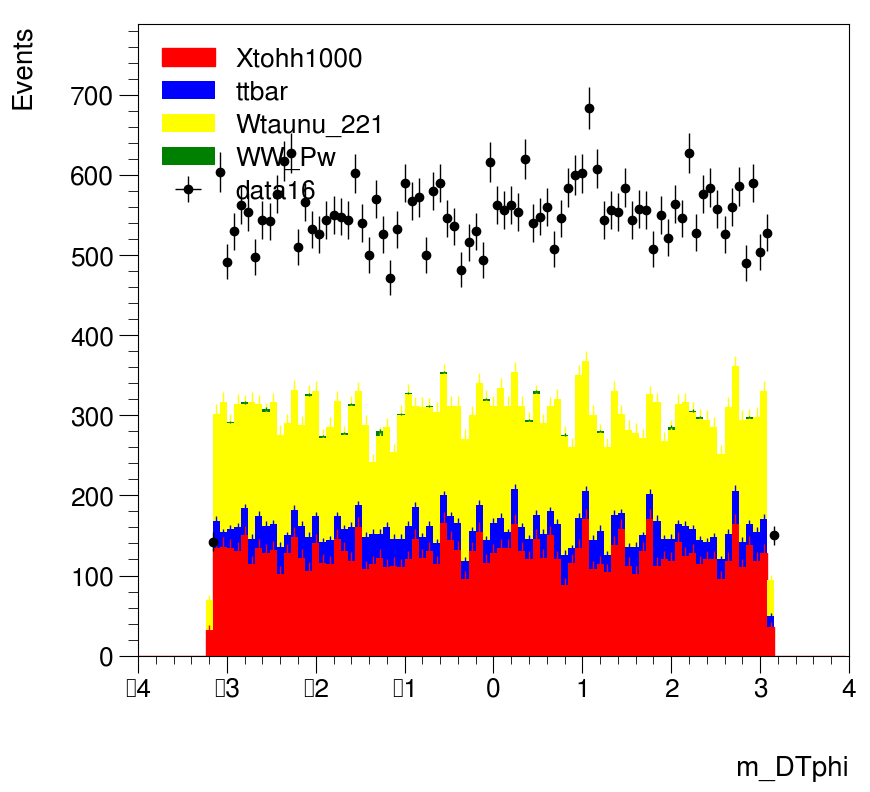

In [24]:
# Base directory
b = "/home/andrea/Escritorio/CERN data/Try3A/"
# Background files array
filesB = [b+"ttbar.root", b+"Wtaunu_221.root", b+"WW_Pw.root"] 
# Signal files array
filesS = [b+"Xtohh1000.root"]
# Data files array
filesD = [b+"data16.root"]
# Histogram generation
hist_gen(filesD, filesB, filesS, "Nominal", "m_DTphi")